# **Code by Joshua Nichols (gustynewguy2214)**

##Import necessary libraries:

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

##Load the CSV data:

In [ ]:
location = '/content/drive/My Drive/Colab Notebooks/input/'
assignment = '4611_HW_3'

original_train = pd.read_csv(location + assignment + '/train.csv')
original_test = pd.read_csv(location + assignment + '/test.csv')
sample_sub = pd.read_csv(location + assignment + '/sample_submission.csv')

train = original_train.copy().drop(columns=['id'])
test = original_test.copy().drop(columns=['id'])

In [ ]:
train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,14.48,21.46,94.25,648.2,0.09444,0.09947,0.120400,0.04938,0.2075,0.05636,0.4204,2.2200,3.301,38.87,0.009369,0.029830,0.05371,0.017610,0.02418,0.003249,16.21,29.25,108.40,808.9,0.1306,0.19760,0.33490,0.12250,0.3020,0.06846,1
1,14.92,14.93,96.45,686.9,0.08098,0.08549,0.055390,0.03221,0.1687,0.05669,0.2446,0.4334,1.826,23.31,0.003271,0.017700,0.02310,0.008399,0.01148,0.002379,17.18,18.22,112.00,906.6,0.1065,0.27910,0.31510,0.11470,0.2688,0.08273,0
2,12.81,13.06,81.29,508.8,0.08739,0.03774,0.009193,0.01330,0.1466,0.06133,0.2889,0.9899,1.778,21.79,0.008534,0.006364,0.00618,0.007408,0.01065,0.003351,13.63,16.15,86.70,570.7,0.1162,0.05445,0.02758,0.03990,0.1783,0.07319,0
3,13.20,17.43,84.13,541.6,0.07215,0.04524,0.043360,0.01105,0.1487,0.05635,0.1630,1.6010,0.873,13.56,0.006261,0.015690,0.03079,0.005383,0.01962,0.002250,13.94,27.82,88.28,602.0,0.1101,0.15080,0.22980,0.04970,0.2767,0.07198,0
4,12.47,17.31,80.45,480.1,0.08928,0.07630,0.036090,0.02369,0.1526,0.06046,0.1532,0.7810,1.253,11.91,0.003796,0.013710,0.01346,0.007096,0.01536,0.001541,14.06,24.34,92.82,607.3,0.1276,0.25060,0.20280,0.10530,0.3035,0.07661,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,15.13,29.81,96.71,719.5,0.08320,0.04605,0.046860,0.02739,0.1852,0.05294,0.4681,1.6270,3.043,45.38,0.006831,0.014270,0.02489,0.009087,0.03151,0.001750,17.26,36.91,110.10,931.4,0.1148,0.09866,0.15470,0.06575,0.3233,0.06165,1
280,25.73,17.46,174.20,2010.0,0.11490,0.23630,0.336800,0.19130,0.1956,0.06121,0.9948,0.8509,7.222,153.10,0.006369,0.042430,0.04266,0.015080,0.02335,0.003385,33.13,23.58,229.30,3234.0,0.1530,0.59370,0.64510,0.27560,0.3690,0.08815,1
281,12.04,28.14,76.85,449.9,0.08752,0.06000,0.023670,0.02377,0.1854,0.05698,0.6061,2.6430,4.099,44.96,0.007517,0.015550,0.01465,0.011830,0.02047,0.003883,13.60,33.33,87.24,567.6,0.1041,0.09726,0.05524,0.05547,0.2404,0.06639,0
282,11.27,15.50,73.38,392.0,0.08365,0.11140,0.100700,0.02757,0.1810,0.07252,0.3305,1.0670,2.569,22.97,0.010380,0.066690,0.09472,0.020470,0.01219,0.012330,12.04,18.93,79.73,450.0,0.1102,0.28090,0.30210,0.08272,0.2157,0.10430,0


##Check for missing values:

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              284 non-null    float64
 1   texture_mean             284 non-null    float64
 2   perimeter_mean           284 non-null    float64
 3   area_mean                284 non-null    float64
 4   smoothness_mean          284 non-null    float64
 5   compactness_mean         284 non-null    float64
 6   concavity_mean           284 non-null    float64
 7   concave points_mean      284 non-null    float64
 8   symmetry_mean            284 non-null    float64
 9   fractal_dimension_mean   284 non-null    float64
 10  radius_se                284 non-null    float64
 11  texture_se               284 non-null    float64
 12  perimeter_se             284 non-null    float64
 13  area_se                  284 non-null    float64
 14  smoothness_se            2

In [ ]:
train.isna().sum()

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
diagnosis                  0
dtype: int64

No missing values, so no action is needed.

##Check for outliers by using the Inter-Quartile Range (IQR):

In [ ]:
x_train = original_train.loc[:, ~original_train.columns.isin(['id', 'diagnosis'])]
y_train = original_train['diagnosis']

x_test = original_test.drop(columns=['id'])

In [ ]:
train_q1 = x_train.quantile(0.25)
train_q3 = x_train.quantile(0.75)
train_overall_IQR = train_q3 - train_q1

((x_train < (train_q1 - 1.5 * train_overall_IQR)) | (x_train > (train_q3 + 1.5 * train_overall_IQR))).sum()

radius_mean                 8
texture_mean                3
perimeter_mean              8
area_mean                  13
smoothness_mean             2
compactness_mean            7
concavity_mean             12
concave points_mean         9
symmetry_mean               8
fractal_dimension_mean     11
radius_se                  17
texture_se                 10
perimeter_se               20
area_se                    28
smoothness_se              16
compactness_se             14
concavity_se               16
concave points_se           9
symmetry_se                10
fractal_dimension_se       21
radius_worst               11
texture_worst               2
perimeter_worst             8
area_worst                 23
smoothness_worst            3
compactness_worst          12
concavity_worst             7
concave points_worst        0
symmetry_worst             16
fractal_dimension_worst    11
dtype: int64

Visualize Them:

In [ ]:
lt1 = train.columns[train.max() <= 1].to_list()
gt1 = train.columns[train.max() > 1].to_list()

lt1a = lt1[:len(lt1)//2]
lt1b = lt1[len(lt1)//2:]
gt1a = gt1[:len(lt1)//2]
gt1b = gt1[len(lt1)//2:]

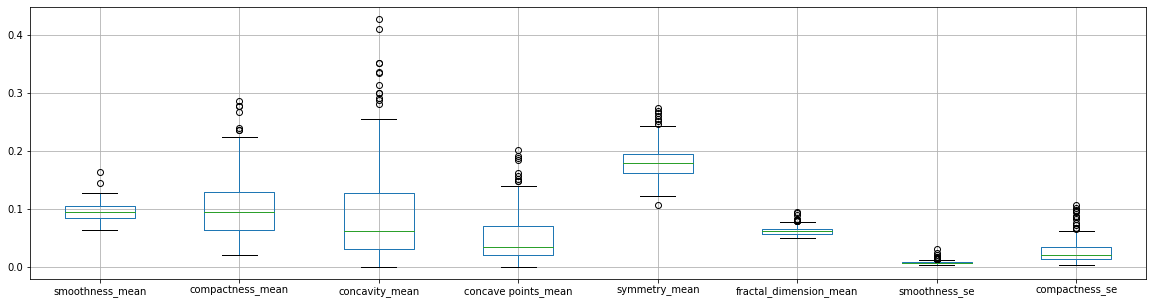

In [ ]:
train.loc[:,lt1a].boxplot(figsize=(20,5))

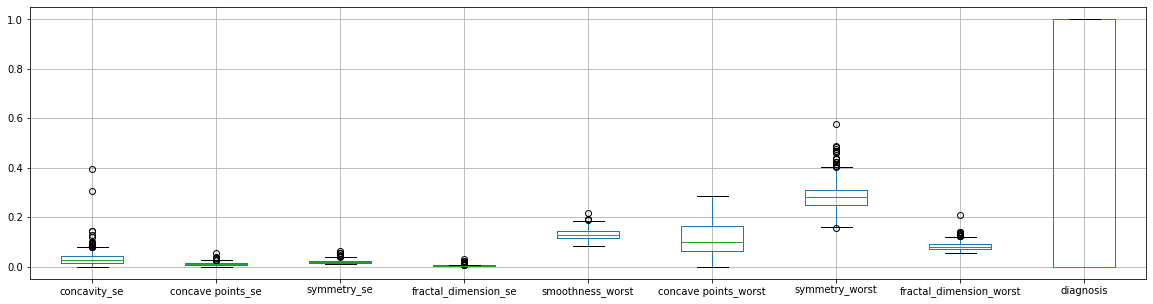

In [ ]:
train.loc[:,lt1b].boxplot(figsize=(20,5))

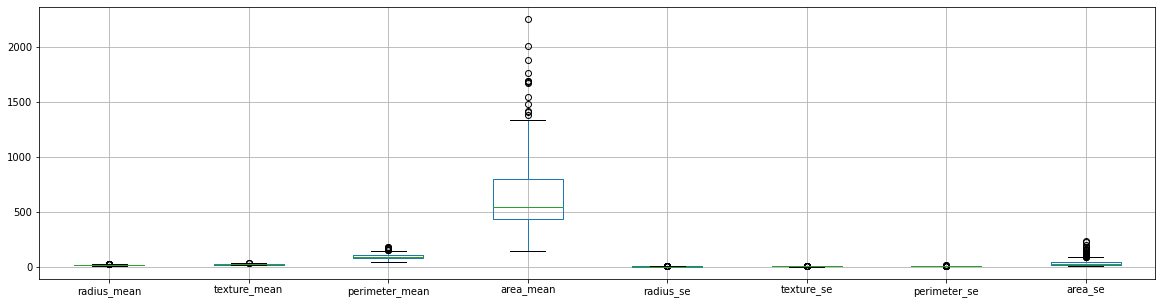

In [ ]:
train.loc[:,gt1a].boxplot(figsize=(20,5))

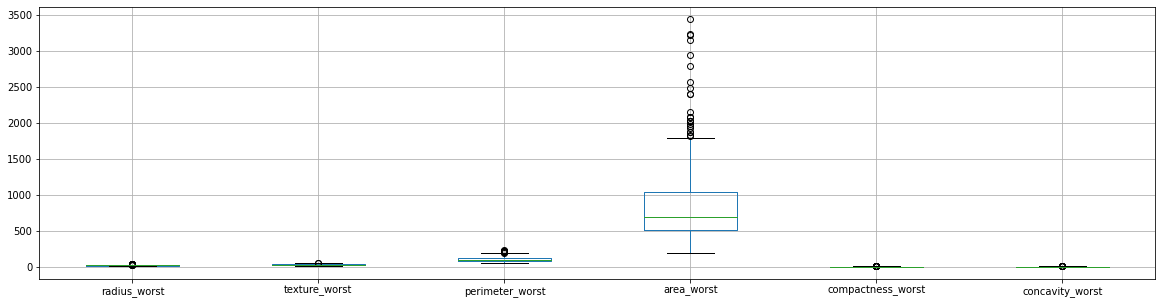

In [ ]:
train.loc[:,gt1b].boxplot(figsize=(20,5))

There are some outliers. However, replacing them with a median value made the model perform worse.

##Check for class imbalance:

In [ ]:
len(train[train['diagnosis'] == 1]) / len(train), len(train[train['diagnosis'] == 0]) / len(train)

(0.3732394366197183, 0.6267605633802817)

Major imbalance. Stratification is needed, which should also help avoid the zero-frequency problem.

##Is Normalization or Standardization Needed?

I chose not to perform either normalization or standardization. 

Naive Bayes' classifiers use MAP predictions where the posterior probabilities for the target feature classes are computed assuming conditional independence. 

From the notes: "Normalization doesn't have an impact on the relative ordering of the MAP [predictions] used by the model. If a class maximizes the posterior, it will maximize it regardless of the size of the normalization constant for the model."

Standardization was not used because it is included already:

From: https://stats.stackexchange.com/questions/254723/standardisation-in-naive-bayes/348165

"For Gaussian Naive Bayes, the estimator learns the mean and standard deviation of each feature (per class). At prediction time the probability of a value being in a class is a function of the distance from the center of the distribution. The function used is Probability Density Function (PDF), of a Normal/Gaussian distribution. And the Normal PDF is just a Standard Normal distribution (0 mean, unit variance) that is scaled by variance and shifted by mean. So a value which is at mean+(0.5*std) has the same probability.

With standardization the mean and stddev changes, but probabilities stay exactly the same, and thus classification results. In essence Gaussian Naive Bayes performs standardization internally."

##Find the best train/test split:

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
def find_best_train_test_split(X,y, splits):
  train_ps = []
  train_f1 = []

  val_ps = []
  val_f1 = []

  X = original_train.iloc[:,:-1].values
  y = original_train.iloc[:,-1].values

  for i in splits:

    print("Checking split: ", i)

    for j in range(50):
      
      X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=i, stratify=y)

      #pipe = make_pipeline()

      folds = 10
      cv = StratifiedKFold(folds)
      n = len(y_train)
      k = max(2,int(n - n * (folds/100.0)) - 1)

      nb_classifier = GaussianNB()

      params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
      model = GridSearchCV(estimator=nb_classifier, 
                      param_grid=params_NB, 
                      cv=cv,   # use any cross validation technique 
                      #verbose=1, 
                      scoring='f1_weighted')
      
      model = model.fit(X_train,y_train)

      y_pred = model.predict(X_train)

      train_ps.append(i)
      train_f1.append(f1_score(y_train, y_pred, average='weighted'))

      y_pred = model.predict(X_val)

      val_ps.append(i)
      val_f1.append(f1_score(y_val, y_pred, average='weighted'))

  return pd.DataFrame({'tpct':val_ps, 'val_f1':val_f1, 'train_f1':train_f1})

def showSplitsGraph(X,y,splits):
  ans = find_best_train_test_split(X,y, splits)
  f, axs = plt.subplots(1,1,figsize=(10,6))
  axs.set_title('Val F1')
  sns.boxplot(data=ans[ans['tpct'] > 0.01], x='tpct', y = 'val_f1', ax=axs)
  f.tight_layout()
  return ans

Checking split:  0.05
Checking split:  0.1
Checking split:  0.15
Checking split:  0.2
Checking split:  0.25
Checking split:  0.3
Checking split:  0.35
Checking split:  0.4
Checking split:  0.45
Checking split:  0.5
Checking split:  0.8
Checking split:  0.85


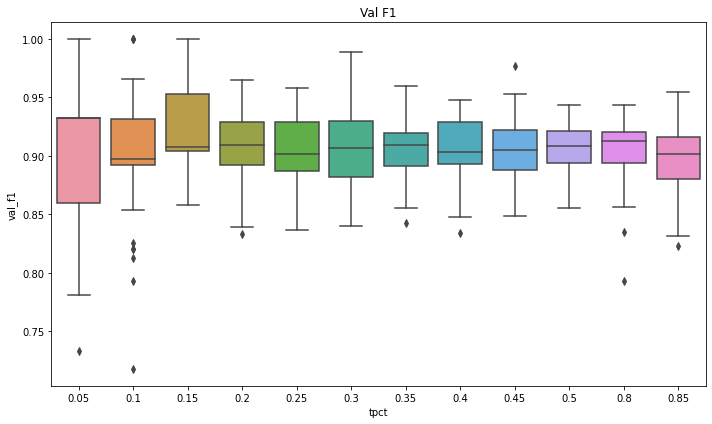

In [ ]:
X = original_train.loc[:, ~original_train.columns.isin(['id', 'diagnosis'])]
y = original_train['diagnosis']
tpct_ranges = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.8, 0.85]
split_res = showSplitsGraph(X,y,tpct_ranges)

In [ ]:
  X = train.loc[:, ~train.columns.isin(['diagnosis'])]
  y = train['diagnosis']

##Make a model with the best Test/Train Ratio. 

(Random state is 7 because I forgot to set it the first time around, so for repeatability purposes I found the seed used.)

Make the prediction using the default model.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state = 7)

In [ ]:
clf = GaussianNB()
model = clf.fit(X_train,y_train)
y_pred = model.predict(X_val)

In [ ]:
f1_score(y_val, y_pred, average='weighted')

0.9169564777575075

In [ ]:
model

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
pred = model.predict(test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
model2 = clf.fit(X_train,y_train)
y_pred = model2.predict(X_val)

In [ ]:
f1_score(y_val, y_pred, average='weighted')

0.8681319071186562

##Which model to use?

I chose to use Gaussian Naive Bayes because:
1. From the notes, probabilities can't be calculated from continuous input features. Instead, we must assume an underlying probability distribution for the data such as the Gaussian distribution or a multinomial distribution.
2. Multinomial is inappropriate, as that is suitable for classification with discrete features (e.g., word counts for text classification). This is supported by the examples provided by the sklearn API, as well as the worse performance of Multinomial shown above.
3. The data comes from natural processes, which are typically modeled as being from normal (Gaussian) distributions.

##Sampling distributions for ROC AUC score, F1 score, and Accuracy score for the training and test data:

In [ ]:
def get_score_dists(X,y,model,mode):
  roc_dst = []
  f1_dst = []
  acc_dst = []
  
  for i in range(200):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)

    fit_model = model
    
    datax = None
    datay = None

    if mode == 'train':
      datax = X_train
      datay = y_train  
    elif mode == 'val':
      datax = X_val
      datay = y_val 
    else:
      return None

    y_pred = fit_model.predict(datax)
    y_pred_true = fit_model.predict_proba(datax)[:,1]
    roc_dst.append(roc_auc_score(datay,y_pred_true))
    f1_dst.append(f1_score(datay,y_pred,average='weighted'))
    acc_dst.append(accuracy_score(datay,y_pred))

  return pd.DataFrame({'roc_dst':roc_dst,'f1_dst':f1_dst,'acc_dst':acc_dst})

def plot_sample_scores(X,y,model,mode, figsize):
  ans = get_score_dists(X,y,model,mode)

  r,c = 1,len(ans.columns)
  f, axs = plt.subplots(r,c,figsize=figsize)
  for col in ans:
    sns.histplot(ans[col],ax=axs[ans.columns.get_loc(col)])

For training data:

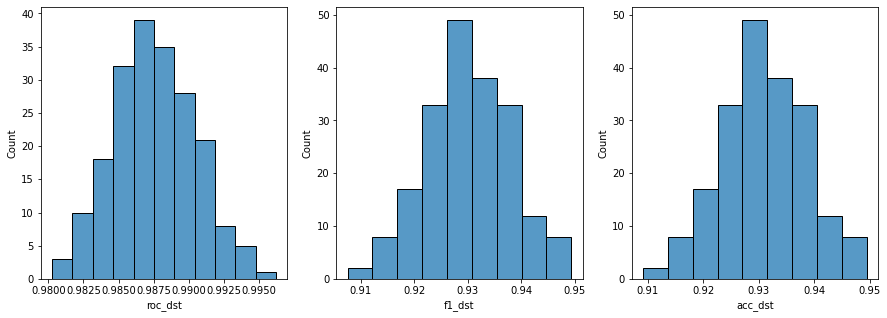

In [ ]:
plot_sample_scores(X,y,model,'train', (15,5))

Again for the validation data:

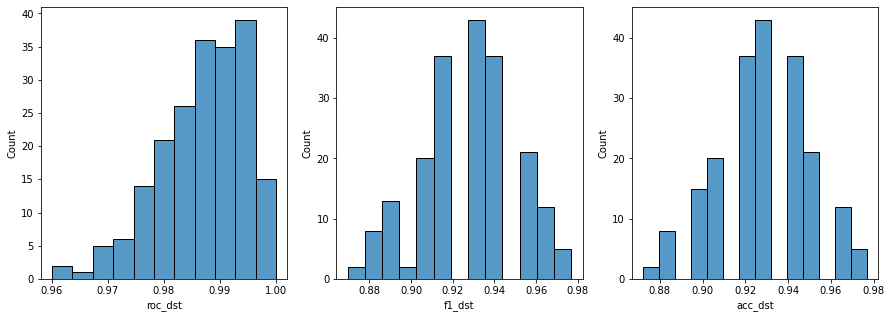

In [ ]:
plot_sample_scores(X,y,model,'val', (15,5))

##Create and show the submission file.

Check lengths to make sure they are compatible.

In [ ]:
len(pred), len(test)

(285, 285)

In [ ]:
submission = pd.DataFrame({
    "id": original_test['id'],
    "diagnosis": pred
})

sub_name = 'submission-' + datetime.now().strftime("%H:%M:%S") + '.csv'

submission.to_csv(sub_name, index=False)

In [ ]:
files.download(sub_name)
print('Created: ', sub_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Created:  submission-14:00:12.csv


Display the results:

In [ ]:
pd.set_option('display.max_rows', len(submission)+1)
submission

,id,diagnosis
0,0,0
1,1,0
2,2,0
3,3,1
4,4,1
5,5,0
6,6,1
7,7,0
8,8,1
9,9,1


This file was last run on Kaggle when:
test_size = 0.3 and f1_weighted = 0.9169564777575075